# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import sys
import seaborn as sns
from PIL import Image
import pickle

import matplotlib.pyplot as plt
import scipy
import math

## Helper Functions

In [2]:
%store -r analysis_hf
sys.path.insert(0, analysis_hf)
import nodalStrength as ns
import normalize as norm

# Set Directory Paths

In [3]:
# Directory path to load formatted Pathology Data
%store -r path_dataDir

# Directory path to save Calcualted Analysis Data
%store -r path_CalData

# Directory path to save Figures
%store -r path_Fig

# [1] Loading

## Loading Covariance Matrices (Dropped)

In [4]:
# covTAU_Drop
with open(os.path.join(path_CalData, 'covTAU_Drop.pkl'), 'rb') as f:
    covTAU_Drop = pickle.load(f)
f.close()

# covTDP_Drop
with open(os.path.join(path_CalData, 'covTDP_Drop.pkl'), 'rb') as f:
    covTDP_Drop = pickle.load(f)
f.close()

In [5]:
# covTAU_gt_TDP_Drop
with open(os.path.join(path_CalData, 'covTAU_gt_TDP_Drop.pkl'), 'rb') as f:
    covTAU_gt_TDP_Drop = pickle.load(f)
f.close()

# covTDP_gt_TAU_Drop
with open(os.path.join(path_CalData, 'covTDP_gt_TAU_Drop.pkl'), 'rb') as f:
    covTDP_gt_TAU_Drop = pickle.load(f)
f.close()

## Loading path_Tau, path_TDP (Dropped)

In [6]:
# path_TAU_Drop
with open(os.path.join(path_dataDir, 'path_TAU_Drop.pkl'), 'rb') as f:
    path_TAU_Drop = pickle.load(f)
f.close()

# path_TDP_Drop
with open(os.path.join(path_dataDir, 'path_TDP_Drop.pkl'), 'rb') as f:
    path_TDP_Drop = pickle.load(f)
f.close()

# Normalize each TAU and TDP separately (to range -1, 1)

In [7]:
# Min/Max Range of Normalizing
t_min = -1
t_max = 1

In [8]:
# normalizing TAU EXCLUDING NaN!
path_TAU_Drop_Norm = norm.normalize2d(path_TAU_Drop, t_min, t_max)

In [9]:
# normalizing TDP EXCLUDING NaN!
path_TDP_Drop_Norm = norm.normalize2d(path_TDP_Drop, t_min, t_max)

# [2] Draw Nodal Strength vs Log %AO

In [10]:
pathOrig = np.concatenate((np.nanmean(path_TAU_Drop_Norm, axis=0), 
                           np.nanmean(path_TDP_Drop_Norm, axis=0)))

ymin = np.min(pathOrig) + 0.01
ymax = np.max(pathOrig) - 0.01

## TAU

<Figure size 640x480 with 0 Axes>

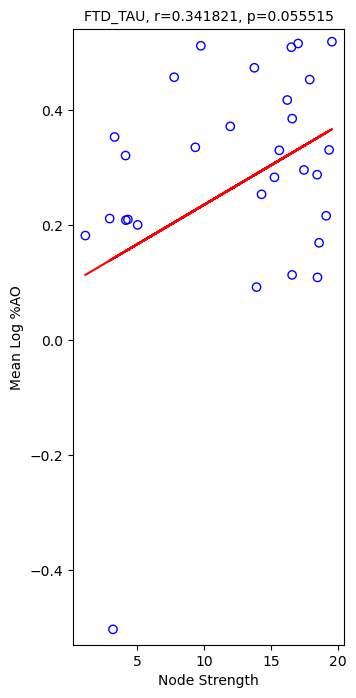

In [11]:
ns.nonZeroDegCorr(path_TAU_Drop_Norm, covTAU_Drop, ymin, ymax,
                  'FTD_TAU', 'Node Strength', 'Mean Log %AO', outputDir = path_Fig, outputName = 'FTD_TAU_NodalStrength', linear_regression = True)

## TDP

<Figure size 640x480 with 0 Axes>

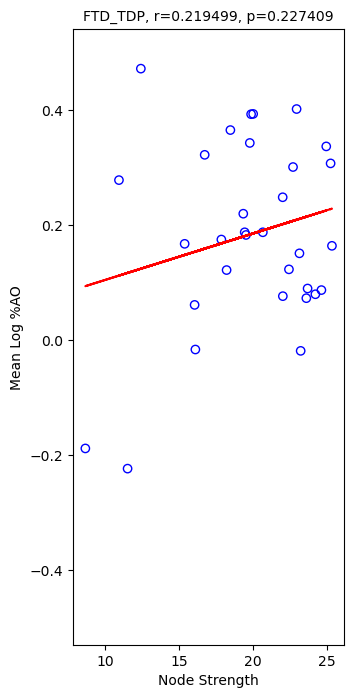

In [12]:
ns.nonZeroDegCorr(path_TDP_Drop_Norm, covTDP_Drop, ymin, ymax,
                  'FTD_TDP', 'Node Strength', 'Mean Log %AO', outputDir = path_Fig, outputName = 'FTD_TDP_NodalStrength', linear_regression = True)

## For figure generation

In [13]:
def nonZeroDegCorr(DataX1, covMatX1, DataX2, covMatX2,
                   title1, title2, titlefont,
                   x_label, y_label, labelfont,
                   outputDir, outputName, linear_regression = False):
    
    # Copy the Covariance Matrix and set negative values as zero
    covMatXnz1 = covMatX1.copy()
    covMatXnz1[covMatXnz1 < 0] = 0
    
    covMatXnz2 = covMatX2.copy()
    covMatXnz2[covMatXnz2 < 0] = 0
    
    # Get sum of covariance values for all regions respective to each region
    # Similar to computing the degree of nodes in a Network
    degX1 = np.sum(covMatXnz1, axis=0, where=~np.isnan(covMatXnz1))
    degX2 = np.sum(covMatXnz2, axis=0, where=~np.isnan(covMatXnz2))
    
    print(degX1)
    
    # Get Y-axis min and max
    combData = np.concatenate((np.nanmean(DataX1, axis=0), 
                               np.nanmean(DataX2, axis=0)))

    ymin = np.min(combData) - 0.1
    ymax = np.max(combData) + 0.1
    
    # Get X-axis (Node Strength) min and max
    combDeg = np.concatenate((degX1, degX2))

    xmin = 0
    xmax = math.ceil(np.max(combDeg) - 0.01)
    
    # Define figure
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 7))
    
    # Data 1
    axs[0].scatter(degX1, np.nanmean(DataX1, axis=0), facecolors='none', edgecolors='b')
    
    # Get r and p-value
    r1, p1 = scipy.stats.pearsonr(degX1, np.nanmean(DataX1, axis=0))
    
    # Data 2
    axs[1].scatter(degX2, np.nanmean(DataX2, axis=0), facecolors='none', edgecolors='b')
    
    # Get r and p-value
    r2, p2 = scipy.stats.pearsonr(degX2, np.nanmean(DataX2, axis=0))
   
    # set x, y-axis range
#     axs[0].set_xlim([xmin, xmax])
#     axs[1].set_xlim([xmin, xmax])

    axs[0].set_ylim([ymin, ymax])
    axs[1].set_ylim([ymin, ymax])

 
    # Set title
    #plt.title(title + f", r={r:.6f}, p={p:.6f}", fontsize=10)
    axs[0].set_title(title1, fontsize = titlefont)
    axs[1].set_title(title2, fontsize = titlefont)
    
    # Draw Linear Regression Line (is set to True)
    if linear_regression:
        # Obtain m (slope) and b(intercept) of linear regression line
        m1, b1 = np.polyfit(degX1, np.nanmean(DataX1, axis=0), 1)
        m2, b2 = np.polyfit(degX2, np.nanmean(DataX2, axis=0), 1)
        
        #add linear regression line to scatterplot 
        axs[0].plot(degX1, m1*degX1+b1, color="red")
        axs[1].plot(degX2, m2*degX2+b2, color="red")

    # Set X and Y Labels
    axs[0].set_xlabel(x_label, fontsize = labelfont)
    axs[0].set_ylabel(y_label, fontsize = labelfont)
    axs[1].set_xlabel(x_label, fontsize = labelfont)
    
    # Record r and p values
    if p1 < 0.05:
        axs[0].text(0.5, -0.12, f'r={r1: .4f}, *p={p1: .4f}', ha='center', va='center', transform=axs[0].transAxes, fontsize=12)
    else:
        axs[0].text(0.5, -0.12, f'r={r1: .4f}, p={p1: .4f}', ha='center', va='center', transform=axs[0].transAxes, fontsize=12)
    
    if p2 < 0.05:
        axs[1].text(0.5, -0.12, f'r={r2: .4f}, *p={p2: .4f}', ha='center', va='center', transform=axs[1].transAxes, fontsize=12)
    else:
        axs[1].text(0.5, -0.12, f'r={r2: .4f}, p={p2: .4f}', ha='center', va='center', transform=axs[1].transAxes, fontsize=12)
    
    # Save Figure
    plt.savefig(os.path.join(outputDir, outputName) + '.png', dpi=400)
    
    # Show Figure
    plt.show()

[13.91914116  9.74905646 11.95545743 18.70235642  4.28896561 17.47331248
 18.48351198 16.58449478  3.29082342  9.11530039 15.2620684  15.62604271
 13.75647546 16.53016175 16.5917827   9.33937318  4.13460817  2.92539798
  7.75097442 19.56765951  4.11278278 18.46102125 18.60417661 19.13571011
  5.01812197  3.17197916 14.2974043  16.22158128 17.03487236 17.90370882
 19.35495905  1.10176306]


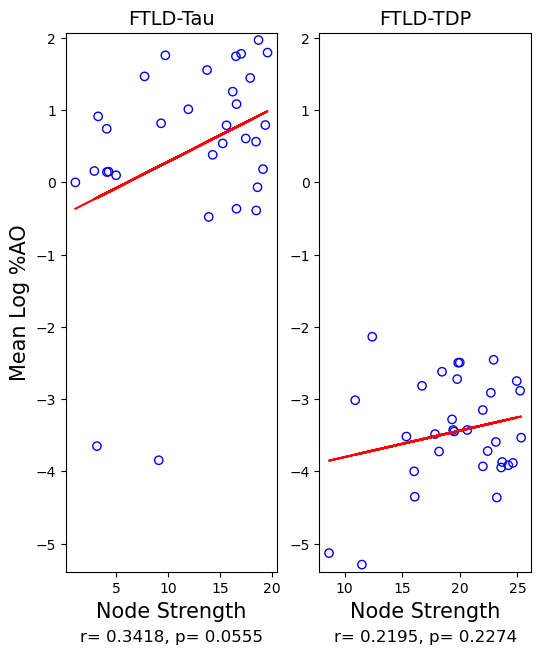

In [14]:
nonZeroDegCorr(path_TAU_Drop, covTAU_Drop, path_TDP_Drop, covTDP_Drop,
               'FTLD-Tau', 'FTLD-TDP', 14,
               'Node Strength', 'Mean Log %AO', 15,
               path_Fig, 'FTD_TauTDP_NodeStrenght(paperfigure1)', 
               linear_regression = True)

[0. 0. 0. 0. 0. 3. 3. 1. 0. 0. 2. 2. 0. 2. 1. 0. 0. 1. 0. 0. 0. 4. 4. 1.
 0. 1. 1. 2. 6. 1. 1. 0.]


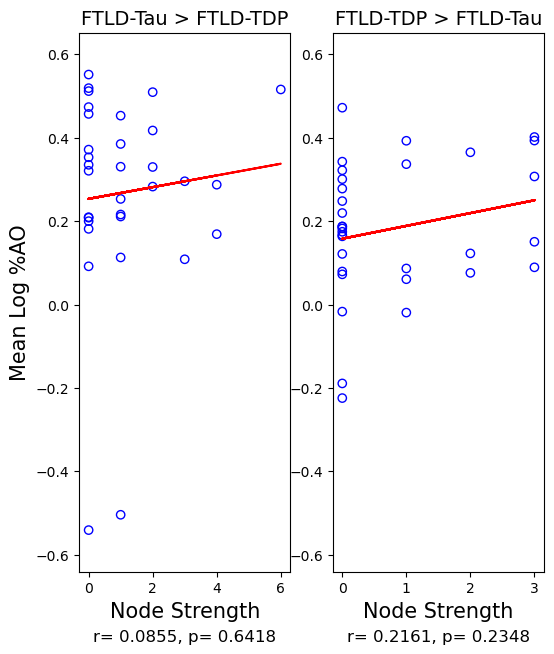

In [15]:
nonZeroDegCorr(path_TAU_Drop_Norm, covTAU_gt_TDP_Drop, path_TDP_Drop_Norm, covTDP_gt_TAU_Drop,
               'FTLD-Tau > FTLD-TDP', 'FTLD-TDP > FTLD-Tau', 14,
               'Node Strength', 'Mean Log %AO', 15,
               path_Fig, 'FTD_TauTDP_NodeStrenght(paperfigure1)', 
               linear_regression = True)